In [9]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins


# Configurações de visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
df = load_penguins()
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [10]:
# Visão geral das colunas, tipos de dados e valores nulos
df.info()

# Estatísticas descritivas das colunas numéricas
df.describe()

# Contagem de valores nulos por coluna
df.isnull().sum()

# Quantidade de valores únicos por coluna
df.nunique()

# Verificar a distribuição de espécies
df["species"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

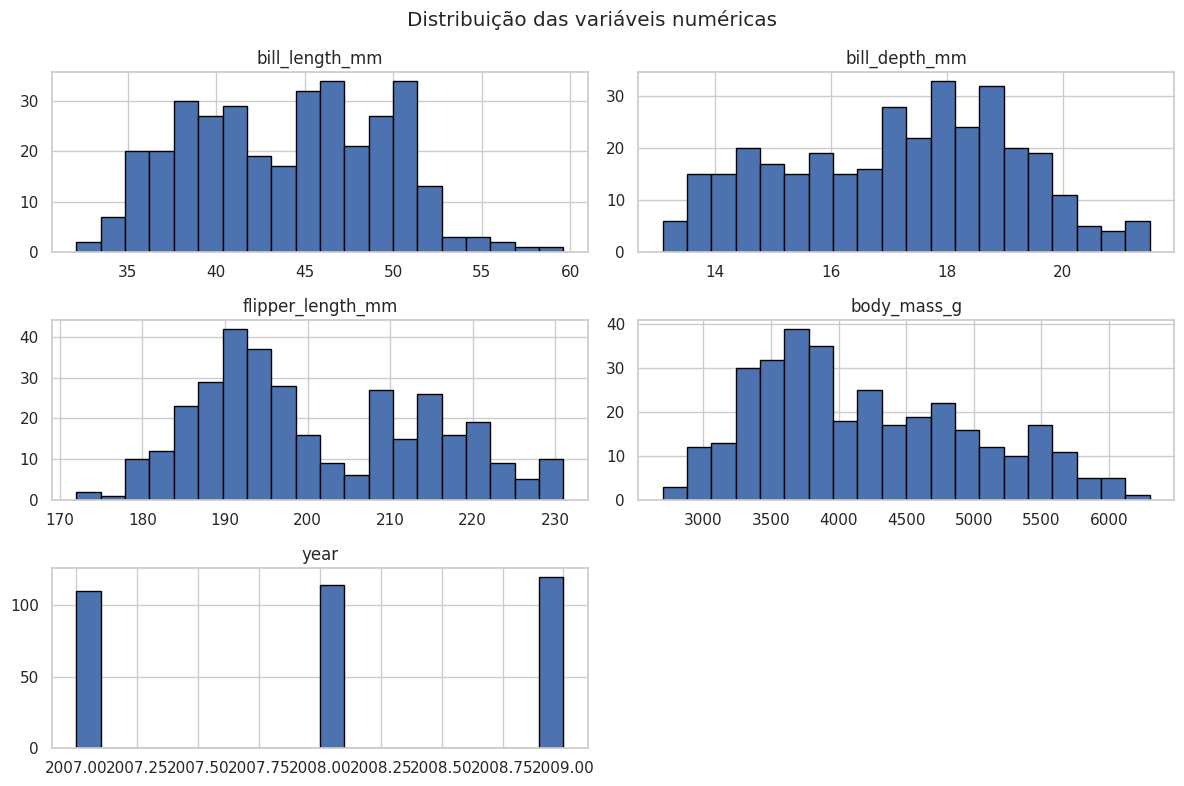

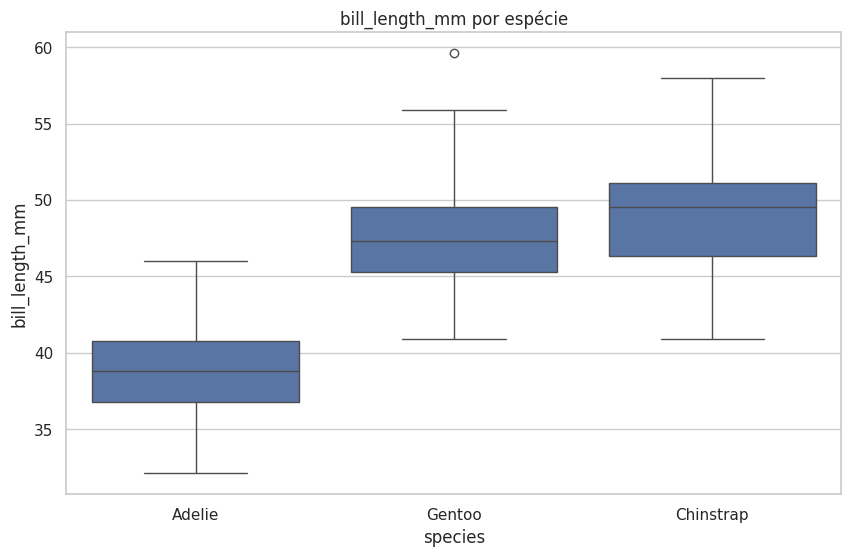

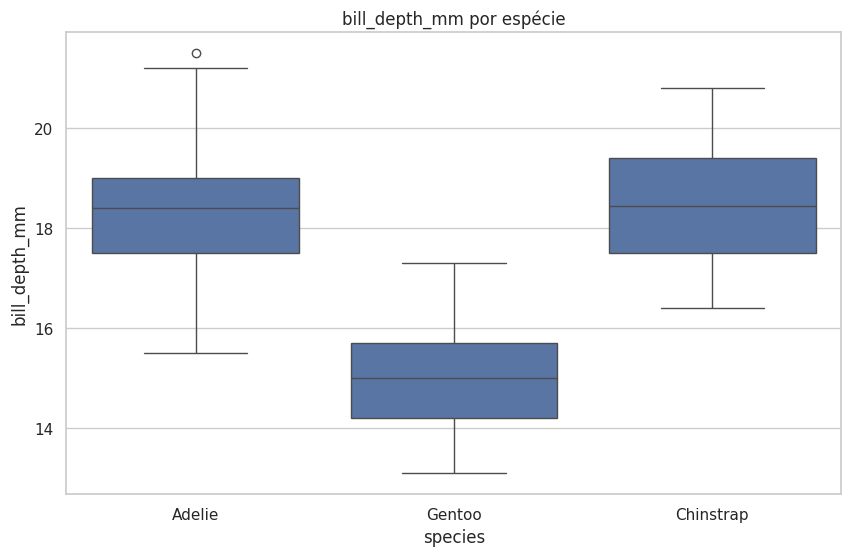

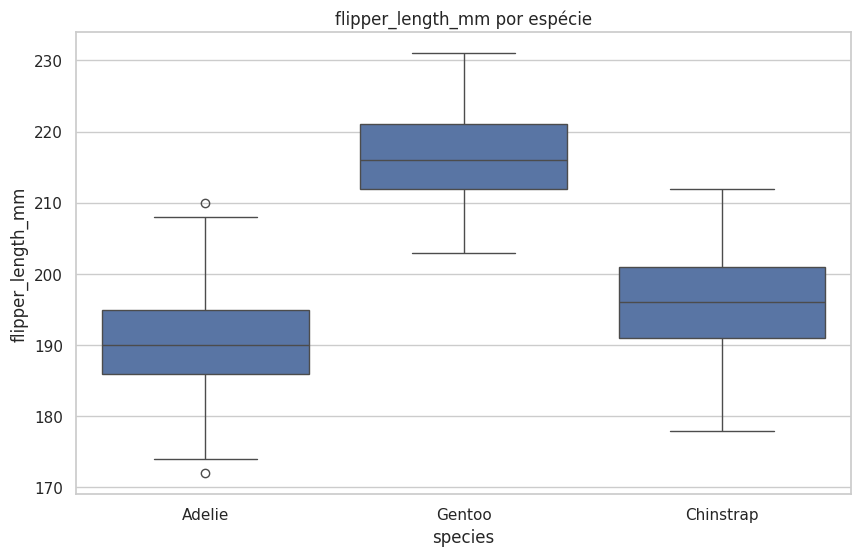

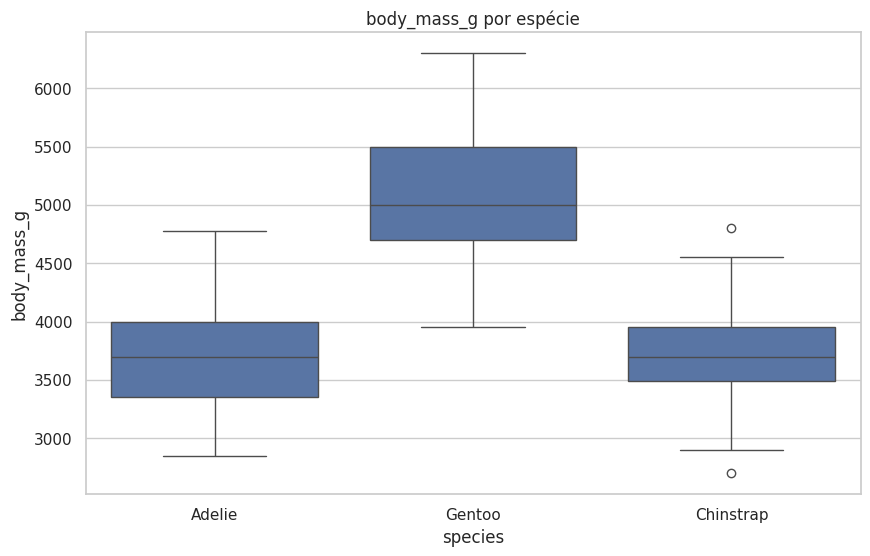

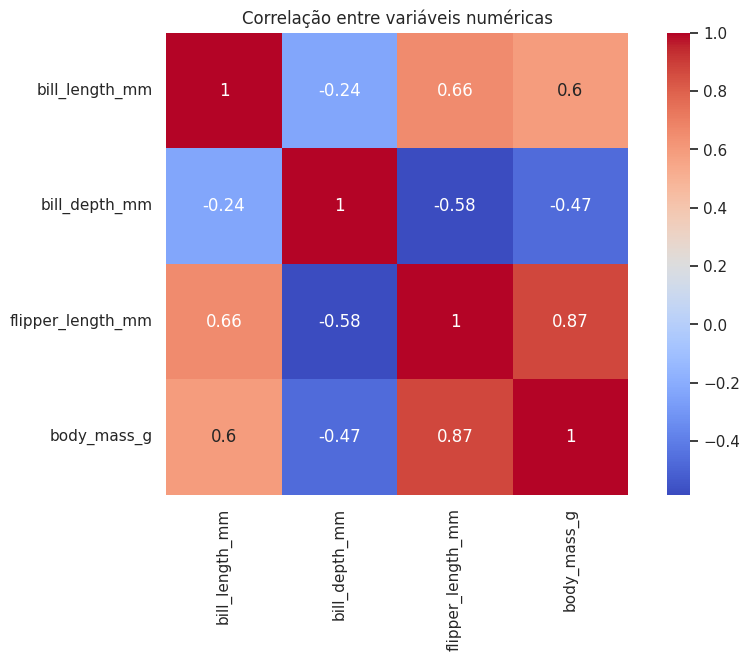

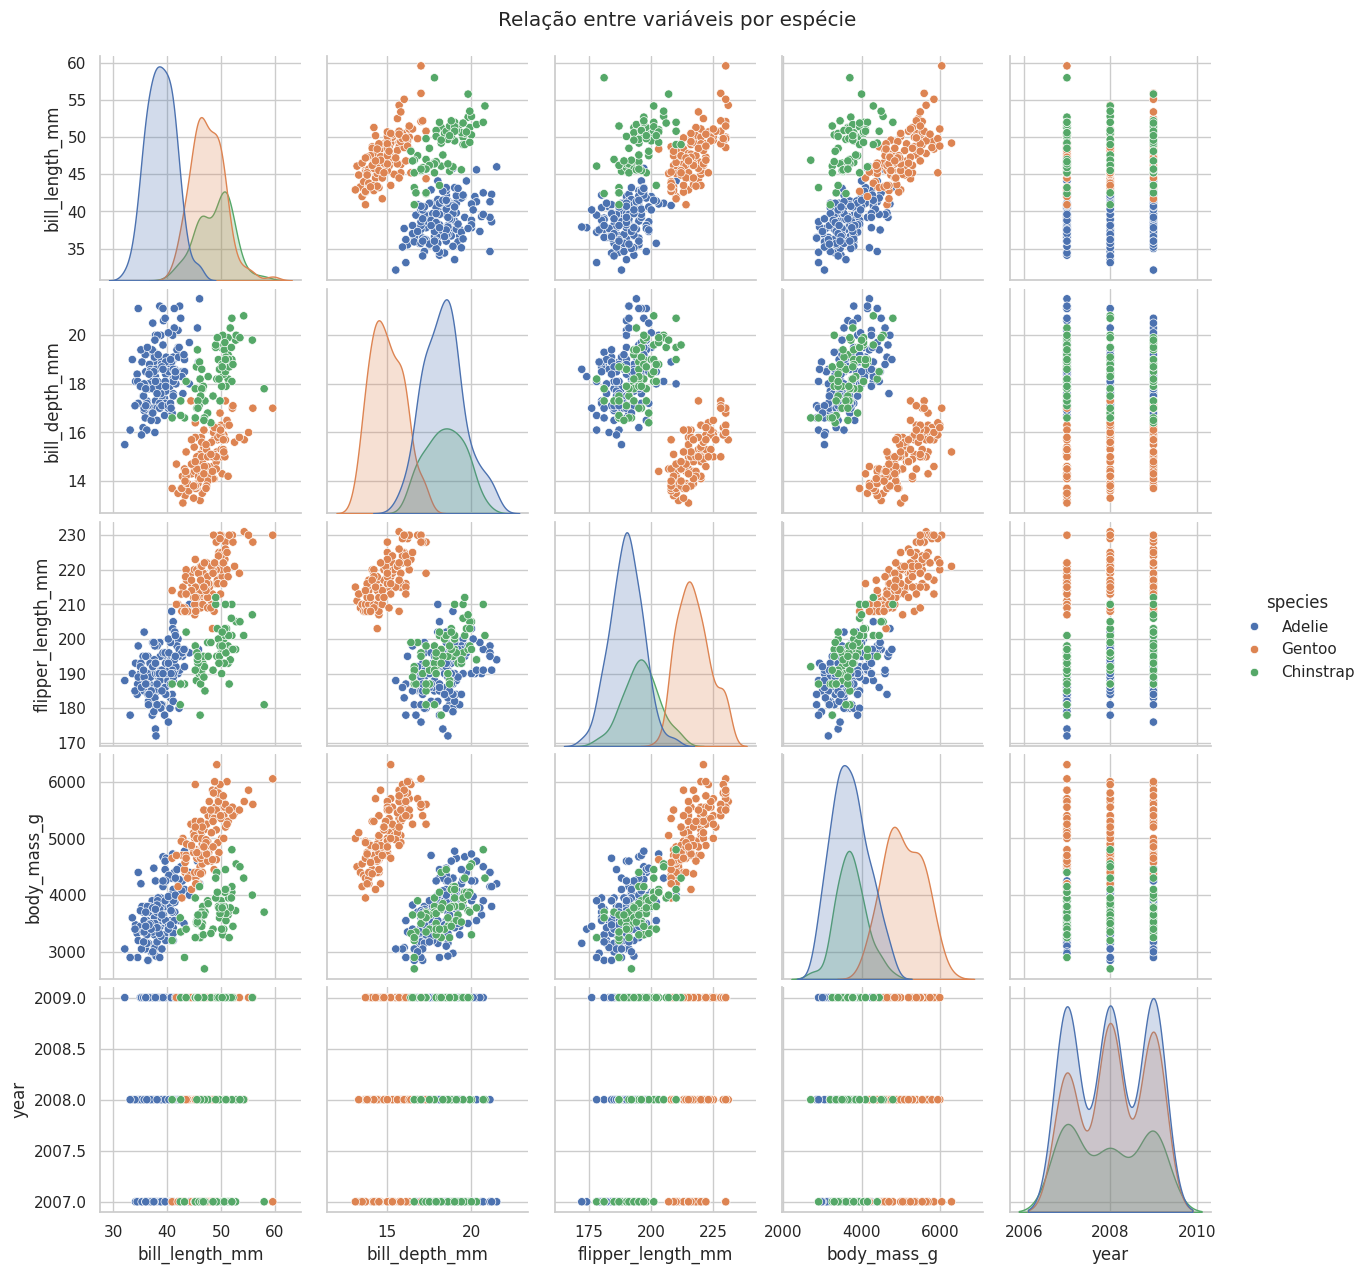

In [11]:
# Histograma para as variáveis numéricas
df.hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distribuição das variáveis numéricas")
plt.tight_layout()
plt.show()

# Boxplots por espécie para detecção de outliers
variaveis_numericas = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

for var in variaveis_numericas:
    sns.boxplot(data=df, x="species", y=var)
    plt.title(f"{var} por espécie")
    plt.show()

# Mapa de calor de correlação
df_corr = df[variaveis_numericas].corr()
sns.heatmap(df_corr, annot=True, cmap="coolwarm", square=True)
plt.title("Correlação entre variáveis numéricas")
plt.show()

# Relações entre variáveis numéricas coloridas por espécie
sns.pairplot(df, hue="species", diag_kind="kde")
plt.suptitle("Relação entre variáveis por espécie", y=1.02)
plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cópia do DataFrame original para não alterar o original
df_tratado = df.copy()

# ➤ Remover colunas irrelevantes ou com muitos nulos
df_tratado.drop(columns=['year'], inplace=True)

# ➤ Remover linhas com valores ausentes
df_tratado.dropna(inplace=True)

# ➤ Conversão de variáveis categóricas em numéricas (One-Hot Encoding)
df_tratado = pd.get_dummies(df_tratado, columns=["island", "sex"], drop_first=True)

# ➤ Criação de bins para body_mass_g (Ex: leve, médio, pesado)
df_tratado["peso_categoria"] = pd.cut(
    df_tratado["body_mass_g"],
    bins=[0, 3500, 4500, np.inf],
    labels=["leve", "médio", "pesado"]
)

# ➤ Codificar nova variável categórica (peso_categoria)
df_tratado = pd.get_dummies(df_tratado, columns=["peso_categoria"], drop_first=True)

# ➤ Separar variáveis preditoras e alvo
X = df_tratado.drop(columns=["species"])
y = df_tratado["species"]

# ➤ Normalização (padronização Z-score)
colunas_numericas = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
scaler = StandardScaler()
X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])

# Verificação final
X.head()


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_male,peso_categoria_médio,peso_categoria_pesado
0,-0.896042,0.780732,-1.426752,-0.568475,False,True,True,True,False
1,-0.822788,0.119584,-1.069474,-0.506286,False,True,False,True,False
2,-0.676280,0.424729,-0.426373,-1.190361,False,True,False,False,False
4,-1.335566,1.085877,-0.569284,-0.941606,False,True,False,False,False
5,-0.859415,1.747026,-0.783651,-0.692852,False,True,True,True,False


In [14]:
# ➤ Separar os dados (80% treino, 20% teste), estratificando por espécie
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treinamento: {X_treino.shape}, Teste: {X_teste.shape}")


Treinamento: (266, 9), Teste: (67, 9)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Modelos a serem testados
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Treinamento dos modelos
for nome, modelo in modelos.items():
    modelo.fit(X_treino, y_treino)
    print(f"✅ Modelo {nome} treinado.")


✅ Modelo Regressão Logística treinado.
✅ Modelo Random Forest treinado.
✅ Modelo KNN treinado.



🔍 Avaliando: Regressão Logística
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



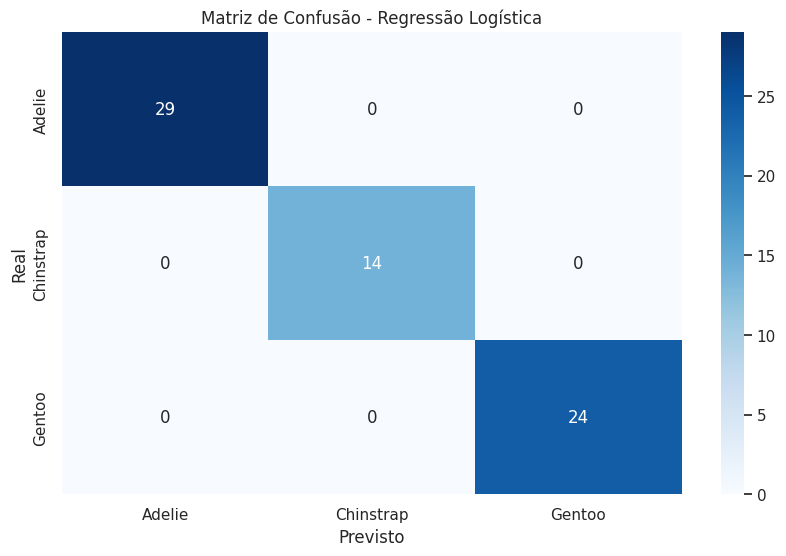


🔍 Avaliando: Random Forest
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



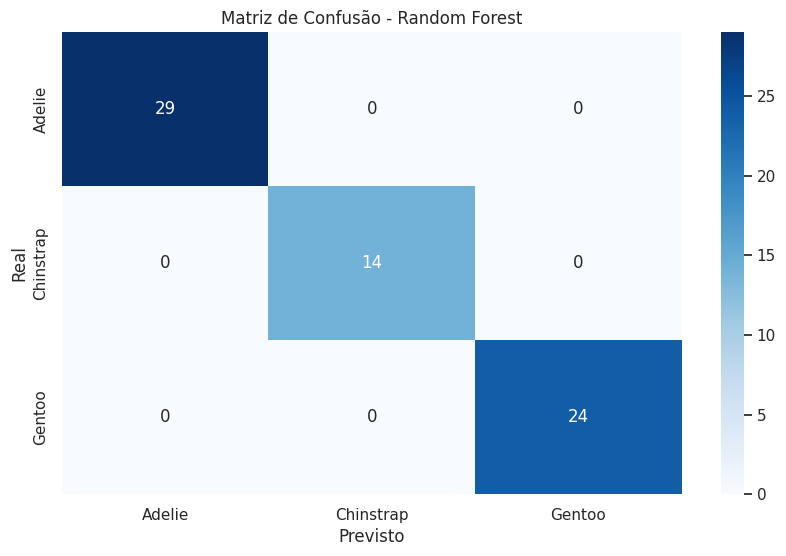


🔍 Avaliando: KNN
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



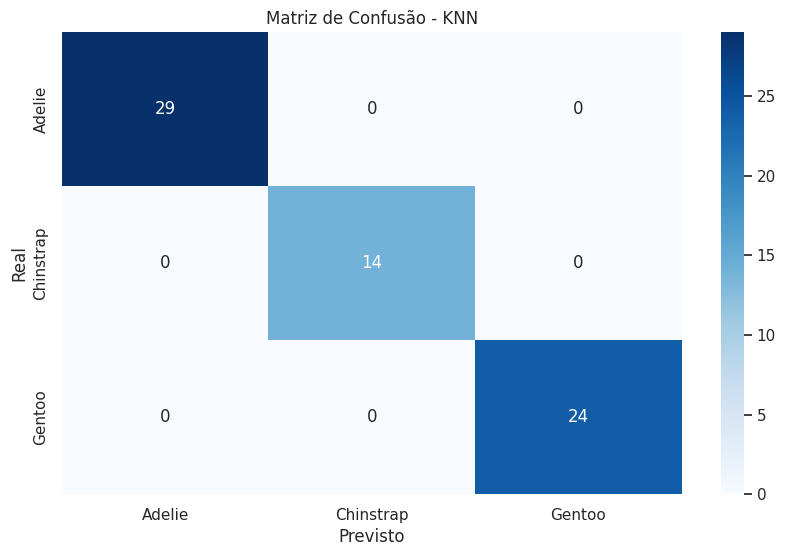

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def avaliar_modelo(modelo, nome):
    print(f"\n🔍 Avaliando: {nome}")
    y_pred = modelo.predict(X_teste)
    
    # Métricas
    acc = accuracy_score(y_teste, y_pred)
    print(f"Acurácia: {acc:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_teste, y_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_teste, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modelo.classes_, yticklabels=modelo.classes_)
    plt.title(f"Matriz de Confusão - {nome}")
    plt.ylabel("Real")
    plt.xlabel("Previsto")
    plt.show()

# Avaliar todos os modelos treinados
for nome, modelo in modelos.items():
    avaliar_modelo(modelo, nome)


Melhores hiperparâmetros:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Melhor acurácia (validação cruzada):
0.9924528301886791

🔍 Avaliando: Random Forest Otimizado
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



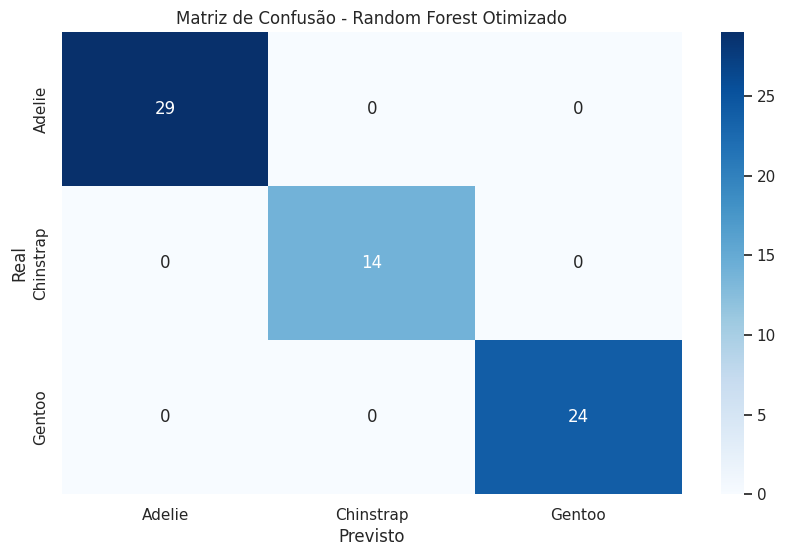

In [18]:
from sklearn.model_selection import GridSearchCV

# Definir grade de hiperparâmetros
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}

# Instanciar modelo base
rf = RandomForestClassifier(random_state=42)

# GridSearch com validação cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Treinamento
grid_search.fit(X_treino, y_treino)

# Resultados
print("Melhores hiperparâmetros:")
print(grid_search.best_params_)

print("\nMelhor acurácia (validação cruzada):")
print(grid_search.best_score_)

# Avaliação no conjunto de teste com o melhor modelo
melhor_modelo = grid_search.best_estimator_
avaliar_modelo(melhor_modelo, "Random Forest Otimizado")


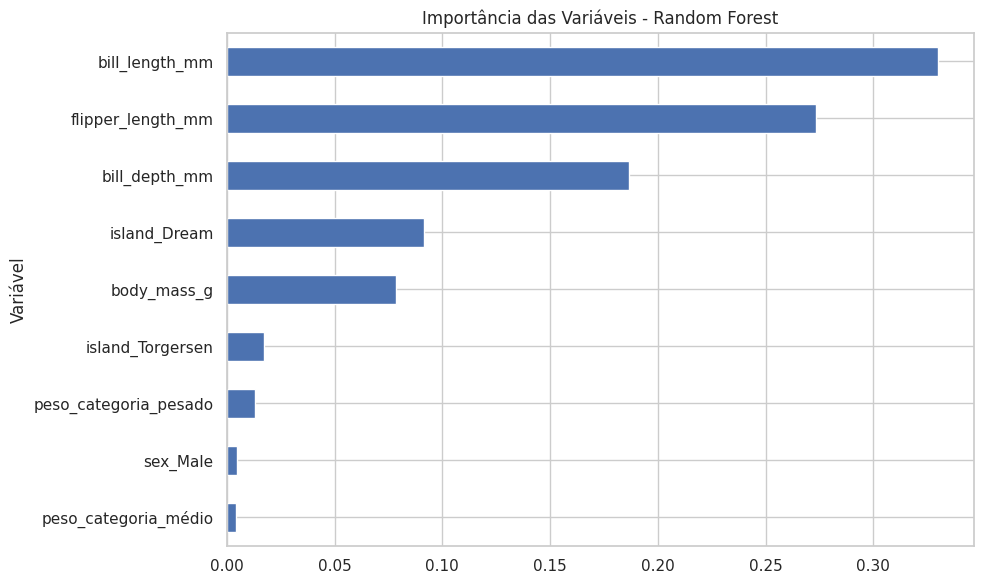

In [26]:
importances = melhor_modelo.feature_importances_
features = X.columns

# Visualizar
import pandas as pd
import matplotlib.pyplot as plt

df_importancia = pd.DataFrame({"Variável": features, "Importância": importances})
df_importancia.sort_values("Importância", ascending=True).plot.barh(x="Variável", y="Importância", legend=False)
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.show()


Melhores hiperparâmetros para KNN:
{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}

Melhor acurácia (validação cruzada):
1.0

🔍 Avaliando: KNN Otimizado
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



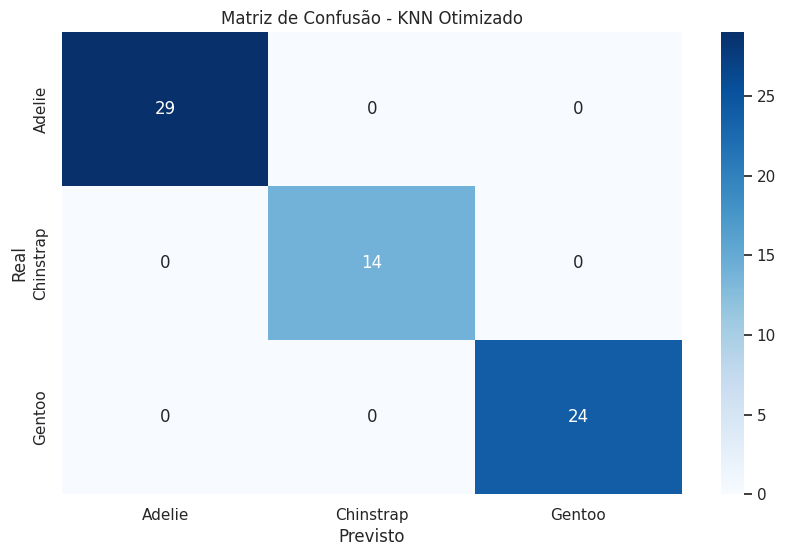

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Grade de hiperparâmetros para KNN
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

# Instanciar o modelo base
knn_base = KNeighborsClassifier()

# Configurar o GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid_knn,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Treinar com os dados de treino
grid_search_knn.fit(X_treino, y_treino)

# Resultados
print("Melhores hiperparâmetros para KNN:")
print(grid_search_knn.best_params_)

print("\nMelhor acurácia (validação cruzada):")
print(grid_search_knn.best_score_)

# Avaliação no conjunto de teste
melhor_knn = grid_search_knn.best_estimator_
avaliar_modelo(melhor_knn, "KNN Otimizado")


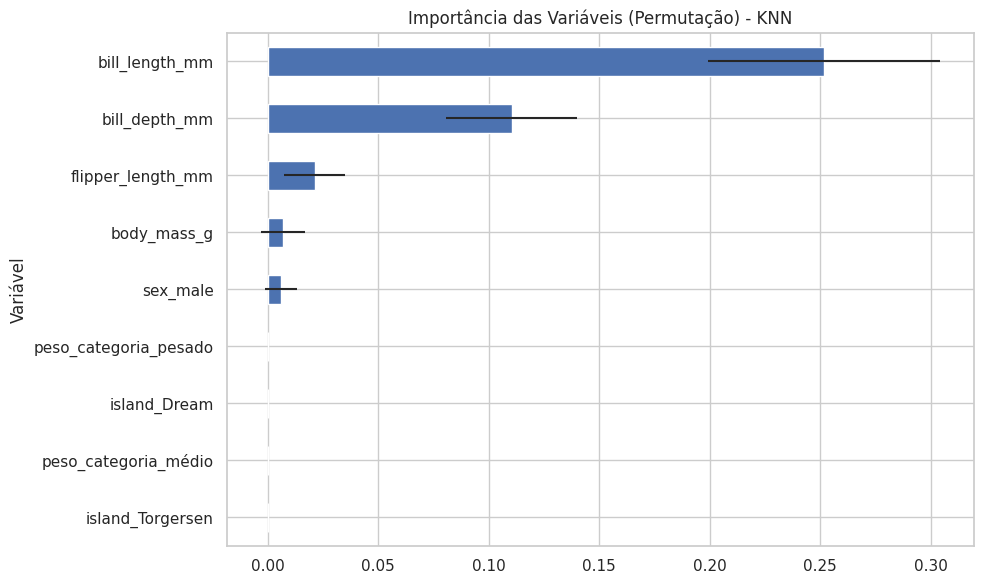

In [22]:
from sklearn.inspection import permutation_importance

# Avaliação de importância com base em permutação
resultado = permutation_importance(melhor_knn, X_teste, y_teste, n_repeats=30, random_state=42, scoring='accuracy')

# Organizar os dados
importancias = pd.DataFrame({
    "Variável": X.columns,
    "Importância Média": resultado.importances_mean,
    "Desvio": resultado.importances_std
}).sort_values(by="Importância Média", ascending=True)

# Gráfico
importancias.plot.barh(x="Variável", y="Importância Média", xerr="Desvio", legend=False)
plt.title("Importância das Variáveis (Permutação) - KNN")
plt.tight_layout()
plt.show()


Acurácia: 0.9850746268656716
ROC AUC: 1.0

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.96      0.98        24

    accuracy                           0.99        67
   macro avg       0.99      0.98      0.98        67
weighted avg       0.99      0.99      0.99        67



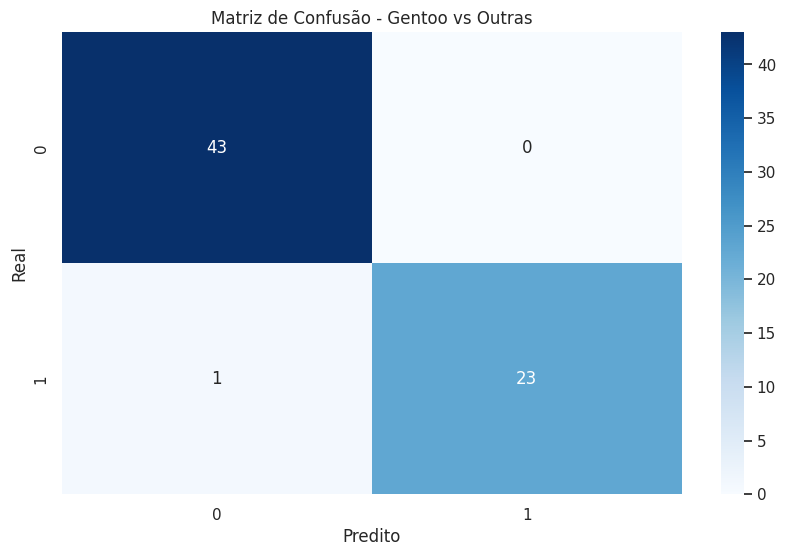

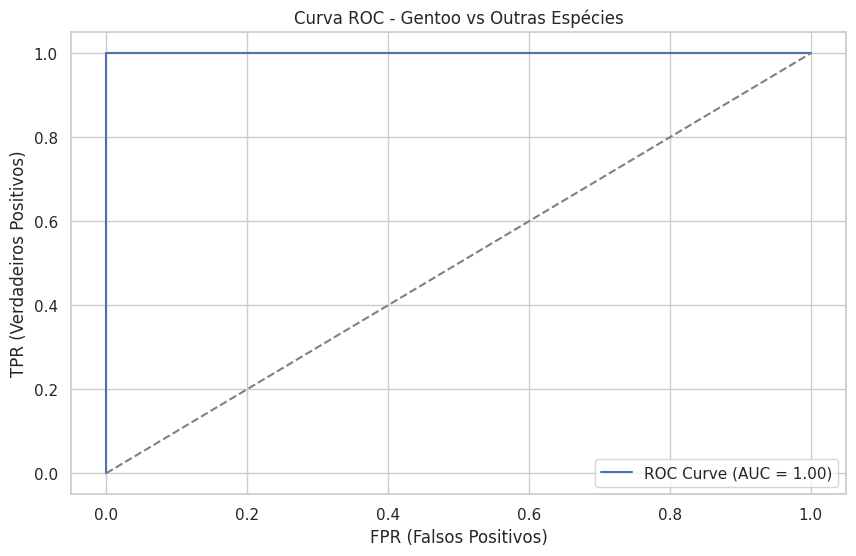

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# 1. Carregar e preparar dados
df = sns.load_dataset("penguins").dropna()

# Variável-alvo binária: 1 se Gentoo, 0 caso contrário
df["is_gentoo"] = (df["species"] == "Gentoo").astype(int)

# One-hot encoding das variáveis categóricas
df = pd.get_dummies(df, columns=["island", "sex"], drop_first=True)

# Selecionar features
X = df[["bill_length_mm", "flipper_length_mm", "body_mass_g", "island_Dream", "island_Torgersen", "sex_Male"]]
y = df["is_gentoo"]

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42, test_size=0.2)

# 2. Treinar modelo binário
modelo_binario = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_binario.fit(X_train, y_train)

# 3. Avaliação
y_pred = modelo_binario.predict(X_test)
y_proba = modelo_binario.predict_proba(X_test)[:, 1]

print("Acurácia:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Gentoo vs Outras")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# 4. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("FPR (Falsos Positivos)")
plt.ylabel("TPR (Verdadeiros Positivos)")
plt.title("Curva ROC - Gentoo vs Outras Espécies")
plt.legend()
plt.grid(True)
plt.show()


Relatório de Classificação:
               precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        37
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       1.00      1.00      1.00        30

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



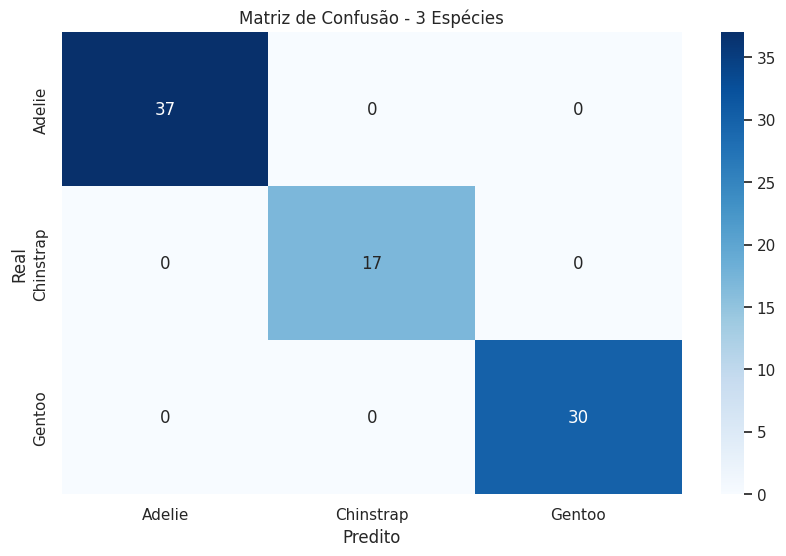

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Carregar dados
df = sns.load_dataset("penguins").dropna()
X = df.drop(columns=["species"])
y = df["species"]

# 2. Codificar variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# 3. Padronizar variáveis numéricas
num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 5. Treinar modelo
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# 6. Avaliação
y_pred = modelo.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d", xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.title("Matriz de Confusão - 3 Espécies")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
